In [8]:
import pandas as pd
import yfinance as yf
import os
from dotenv import load_dotenv
import fredapi
from fredapi import Fred
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [9]:
api_key = os.getenv('FRED_API_KEY')
fred = Fred(api_key=api_key)

In [10]:
# Consumer Price Index for All Urban Consumers: All Items in U.S. City Average (CPIAUCSL)
cpi = fred.get_series('CPIAUCSL', observation_start='1990-01-01')
cpi

1990-01-01    127.500
1990-02-01    128.000
1990-03-01    128.600
1990-04-01    128.900
1990-05-01    129.100
               ...   
2020-12-01    261.560
2021-01-01    262.231
2021-02-01    263.161
2021-03-01    264.793
2021-04-01    266.832
Length: 376, dtype: float64

<AxesSubplot:title={'center':'Consumer Price Index for All Urban Consumers: All Items in U.S. City Average (CPIAUCSL)'}, xlabel='Date', ylabel='cpi index 1982-1984 = 100'>

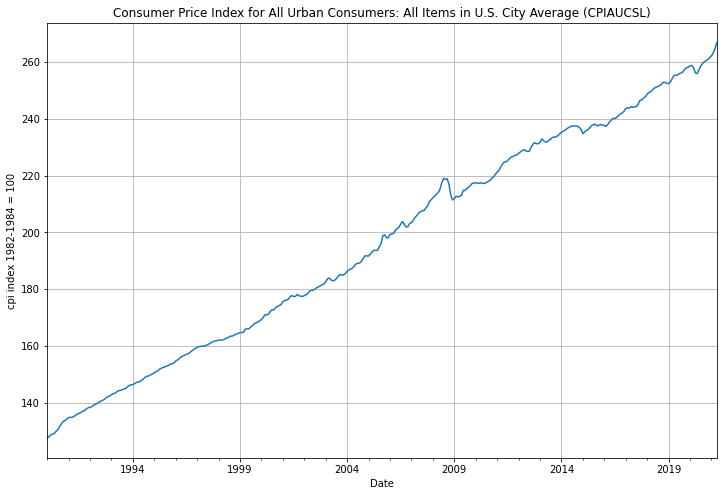

In [11]:
# Plot CPI data
cpi.plot(figsize=(12,8), title='Consumer Price Index for All Urban Consumers: All Items in U.S. City Average (CPIAUCSL)', grid=True, xlabel='Date', ylabel='cpi index 1982-1984 = 100')

In [12]:
# Pull S&P 500 historical data; set freq to monthly
ticker = "^GSPC" 
start= "1990-01-01" 
end= "2021-05-14"

sp_history = yf.download(ticker, start=start, end=end, progress=False)
sp_history = sp_history.asfreq(freq='M').ffill().dropna()
sp_history.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1990-01-31,322.980011,329.079987,322.980011,329.079987,329.079987,189660000.0
1990-02-28,330.260010,333.480011,330.160004,331.890015,331.890015,184400000.0
1990-03-31,330.260010,333.480011,330.160004,331.890015,331.890015,184400000.0
1990-04-30,329.109985,331.309998,327.760010,330.799988,330.799988,122750000.0
1990-05-31,360.859985,361.839996,360.230011,361.230011,361.230011,165690000.0


In [13]:
cpi_percent_change = cpi.pct_change().dropna()
cpi_percent_change

1990-02-01    0.003922
1990-03-01    0.004687
1990-04-01    0.002333
1990-05-01    0.001552
1990-06-01    0.006197
                ...   
2020-12-01    0.002426
2021-01-01    0.002565
2021-02-01    0.003546
2021-03-01    0.006202
2021-04-01    0.007700
Length: 375, dtype: float64

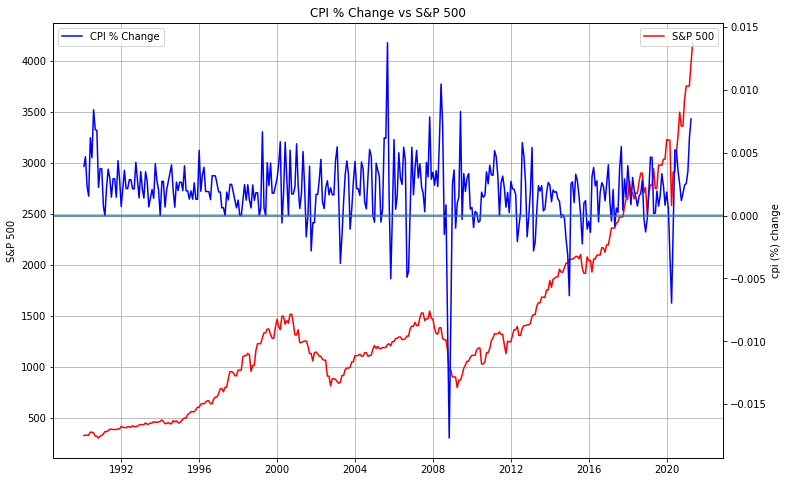

In [14]:
#Plot CPI % Change against S&P 500 index
fig, ax = plt.subplots(figsize=(12,8))
plt.plot(sp_history['Adj Close'], label ='S&P 500', color='r')
ax.set_ylabel('S&P 500')
plt.grid()
ax.legend(loc='upper right')

ax2 = ax.twinx()
plt.plot(cpi_percent_change, label='CPI % Change', color='b')
ax.set_title('CPI % Change vs S&P 500')
ax2.set_ylabel('cpi (%) change')
ax2.axhline(0)
ax2.legend(loc='upper left')